In [101]:
import matplotlib as mpl
import cartopy.crs as ccrs
import os, sys
import xarray as xr
import numpy as np
import scipy.stats as st
import xrft
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import netCDF4 as nc
import matplotlib.ticker as mticker
from matplotlib import colors
import k_omega_functions as kw
import numpy_groupies

In [102]:
def k_omega_spectrum(KE_in, dx, dy):
# Function to compute k_omega spectrum
# KE_in : KE (time_counter, y, x) (loaded with xarray)
# ds_coord : dataset which contains the coordinates(at least e1t & e2t)

    Ny = len(KE_in.y)
    Nx = len(KE_in.x)
    dx = dx / 1000
    dy = dy / 1000
    KE = xr.DataArray(KE_in.values, dims=['time_counter','YC','XC'],
                              coords={'time_counter': np.arange(len(KE_in.time_counter)) ,
                                      'YC':np.arange(0,Ny*dy,dy),
                                      'XC':np.arange(0,Nx*dx,dx)})
    FKE = xrft.fft(xrft.fft(KE.fillna(0.),
                                     dim=['YC', 'XC'], window='hann', detrend='constant',
                                     true_phase=True, true_amplitude=True
                                    ),
                            dim=['time_counter'], window='hann', detrend='constant',
                            true_phase=True, true_amplitude=True
                           )

    FKE = FKE.isel(freq_time_counter=slice(len(FKE.freq_time_counter)//2,None)) * 2

    isoFKE = kw.isotropize(kw.density(np.abs(FKE)**2, ['freq_time_counter','freq_YC','freq_XC']), ['freq_YC','freq_XC'], nfactor=1, kwargs={'truncate':True}).compute()
#     isoFKE = kw.isotropize(np.abs(FKE)**2, ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}).compute()
    
    return isoFKE

In [103]:
def plot_k_omega_spectrum(ax, isoFKE):

    cmap = 'Spectral_r'

    im0 = ax.pcolormesh(isoFKE.freq_r.isel(freq_r=slice(1,None)) ,
                          isoFKE.freq_time_counter.isel(freq_time_counter=slice(1,None))  ,
                          (isoFKE.isel(freq_r=slice(1,None),freq_time_counter=slice(1,None)).values),
                          cmap=cmap,
                          norm=clr.LogNorm(vmin=1e-6, vmax=1e-2),
                          shading='auto', rasterized=True)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-3,None])
#    ax.set_xlim([1e-3,None])
    ax.set_xlabel('wavenumber (cpkm)')
    ax.set_ylabel('frequency (cph)')

    fig.colorbar(im0, ax=ax)



In [104]:
# Define area names
# areanames=['ATL_46N']
# colors=['r']
# listlat_center=np.array([46])
# listlon_center=np.array([-7])
# dx = [2193]
# dy = [2169]

areanames=['WMED']
colors=['g']
listlat_center=np.array([40])
listlon_center=np.array([4])
dx = [2380]
dy = [2260]

# DSTART='2017-12-01'
# DEND='2018-03-01'
# season='DJF'


DSTART='2017-06-01'
DEND='2017-09-01'
season='JJA'

In [105]:
fldr_1 = '/data/vdi/tbrivoal/RUNS_DATA/EXP02_AGRIF_finaldomain_bathycorrected_qco_boost2_noslip/'
fldr_2 = '/data/vdi/tbrivoal/RUNS_DATA/eNEATL36_trunk_r4_2-RC_r15113_IFS_EXP02_2017_2018_AGRIFTWIN_BFR/'
fldr_plots ='/home/tbrivoal/Documents/PLOTS/SPECTRUMS/'

KE files exists, skipping KE computation part
loading file :  /data/vdi/tbrivoal/RUNS_DATA/EXP02_AGRIF_finaldomain_bathycorrected_qco_boost2_noslip/eNEATL36_1h_gridKE_WMED.nc
loading file :  /data/vdi/tbrivoal/RUNS_DATA/eNEATL36_trunk_r4_2-RC_r15113_IFS_EXP02_2017_2018_AGRIFTWIN_BFR/eNEATL36_1h_gridKE_WMED.nc
FIG SAVED HERE: /home/tbrivoal/Documents/PLOTS/SPECTRUMS/k_omega_spectrumWMED_JJA.png


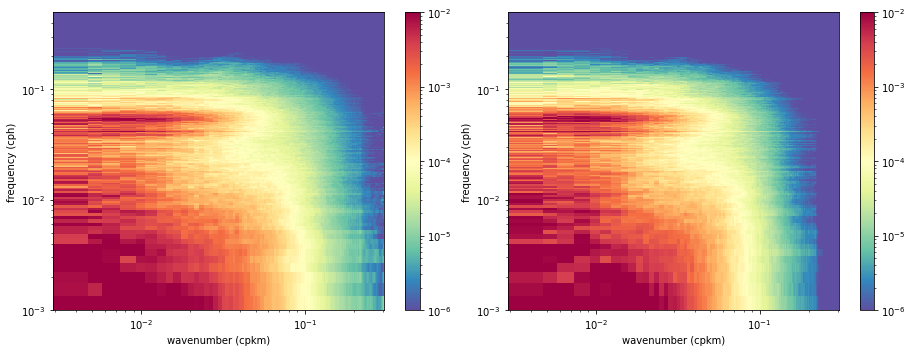

In [106]:
for narea in range(len(listlat_center)):
    # Selecting SSH area
    # This part is to extract the dx and dy 

    file_U_1 = fldr_1+'eNEATL36_1h_gridU_'+str(areanames[narea])+'.nc'
    file_V_1 = fldr_1+'eNEATL36_1h_gridV_'+str(areanames[narea])+'.nc'
    file_KE_1 = fldr_1+'eNEATL36_1h_gridKE_'+str(areanames[narea])+'.nc'

    file_U_2 = fldr_2+'eNEATL36_1h_gridU_'+str(areanames[narea])+'.nc'
    file_V_2 = fldr_2+'eNEATL36_1h_gridV_'+str(areanames[narea])+'.nc'
    file_KE_2 = fldr_2+'eNEATL36_1h_gridKE_'+str(areanames[narea])+'.nc'
    
    # The better is to pre-compute KE, as it takes a long time to compute
    isfile1 = os.path.isfile(file_KE_1)
    isfile2 = os.path.isfile(file_KE_2)

    if isfile1 and isfile2:
        print('KE files exists, skipping KE computation part')
        print('loading file : ', file_KE_1)
        print('loading file : ', file_KE_2)

        ds_KE_1 = xr.open_dataset(file_KE_1)
        ds_KE_2 = xr.open_dataset(file_KE_2)

        KE_1 = ds_KE_1.KE.sel(time_counter=slice(DSTART, DEND))
        KE_2 = ds_KE_2.KE.sel(time_counter=slice(DSTART, DEND))
    else:
    
        ds_U_1 = xr.open_dataset(file_U_1)
        ds_V_1 = xr.open_dataset(file_V_1)
        ds_U_2 = xr.open_dataset(file_U_2)
        ds_V_2 = xr.open_dataset(file_V_2)
        U_1 = ds_U_1.sozocrtx.squeeze()
        V_1 = ds_V_1.somecrty.squeeze()
        U_2 = ds_U_2.sozocrtx.squeeze()
        V_2 = ds_V_2.somecrty.squeeze()
        KE_1 = 0.5 * (U_1.rename('KE')**2 + V_1.rename('KE')**2)
        KE_2 = 0.5 * (U_2.rename('KE')**2 + V_2.rename('KE')**2)
        KE_1.to_netcdf(file_KE_1)
        KE_2.to_netcdf(file_KE_2)
        KE_1 = KE_1.sel(time_counter=slice(DSTART, DEND))
        KE_1 = KE_1.sel(time_counter=slice(DSTART, DEND))        
        
    isoFKE_1 = k_omega_spectrum(KE_1, dx[narea], dy[narea])
    isoFKE_2 = k_omega_spectrum(KE_2, dx[narea], dy[narea])
 
    fig, axes = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
    fig.set_tight_layout(True)
    ax00 = axes[0]
    ax01 = axes[1]
    plot_k_omega_spectrum(ax00, isoFKE_1)
    plot_k_omega_spectrum(ax01, isoFKE_2)

    plt.savefig(fldr_plots + 'k_omega_spectrum'+str(areanames[narea])+'_'+season+'.png')
    print('FIG SAVED HERE: ' + fldr_plots + 'k_omega_spectrum'+str(areanames[narea])+'_'+season+'.png')